Installing dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

Remove dodgy images

In [ ]:
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir ='/content/drive/MyDrive/image sentiment classifier data'

In [ ]:
image_exts =['jpeg','bmp','jpg','png']

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img =cv2.imread(image_path)
      tip =imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with images{}'.format(image_path))


Load data

In [ ]:
data =keras.utils.image_dataset_from_directory(data_dir,batch_size=16)

Found 156 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
#Get another batch from the iterator
batch = data_iterator.next()

In [ ]:
# Images represented as numpy array
batch[0].shape

(16, 256, 256, 3)

In [ ]:
#class 1 = Sad people
#class 0 = Happy people
batch[1]

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1], dtype=int32)

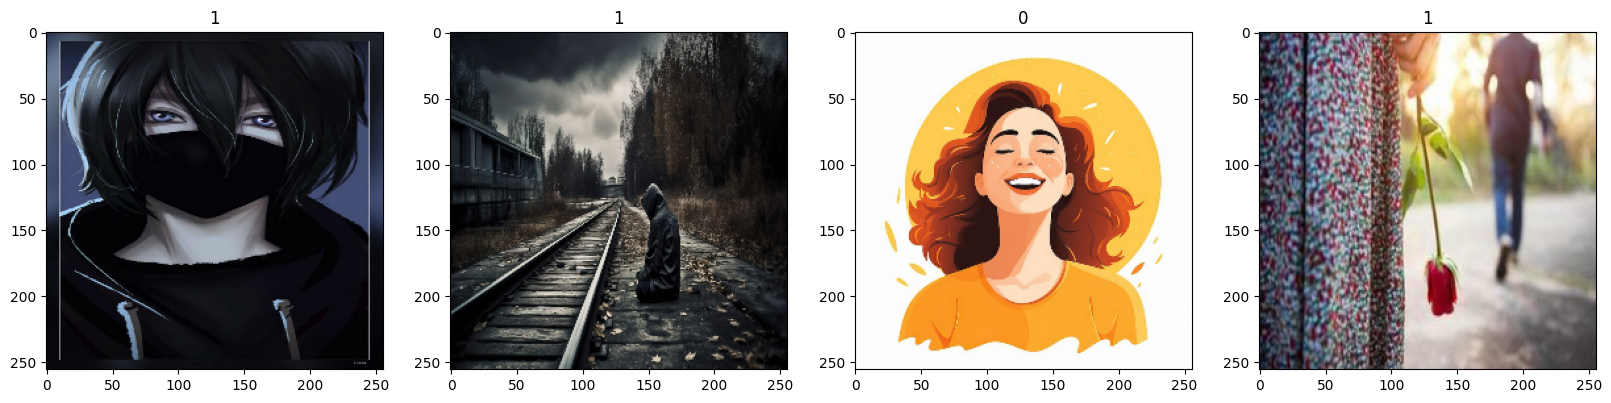

In [ ]:
fig ,ax =plt.subplots(ncols =4,figsize=(20,20))
for idx ,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Preprocess data

In [ ]:
data =data.map(lambda x,y:(x/255,y))

Split data

In [ ]:
a = len(data)

In [ ]:
train_size = int(a*0.7)
val_size =int(a*0.2)
test_size =int(a*0.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test =data.skip(train_size+val_size).take(test_size)

Deep Model

In [34]:
from keras import Sequential
from keras.layers import Conv2D , MaxPooling2D ,Dense,Flatten ,Dropout

In [35]:
model =Sequential()

In [36]:
model.add(Conv2D(16,(3,3),1,activation ='relu',input_shape =(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation ='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation ='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation ='sigmoid'))


In [37]:
from keras.src.backend import binary_crossentropy
model.compile(optimizer='adam' ,loss='binary_crossentropy' ,metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [39]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode="min", patience=5,restore_best_weights=True)

In [40]:
hist =model.fit(train , validation_data= val ,epochs =20 ,callbacks =[earlystopping])

Epoch 1/20
7/7 [==============================] - 18s 657ms/step - loss: 0.8640 - accuracy: 0.5179 - val_loss: 0.6611 - val_accuracy: 0.7500
Epoch 2/20
7/7 [==============================] - 5s 394ms/step - loss: 0.6537 - accuracy: 0.5446 - val_loss: 0.5712 - val_accuracy: 0.8750
Epoch 3/20
7/7 [==============================] - 4s 393ms/step - loss: 0.5981 - accuracy: 0.8036 - val_loss: 0.5206 - val_accuracy: 0.9062
Epoch 4/20
7/7 [==============================] - 5s 548ms/step - loss: 0.5420 - accuracy: 0.8482 - val_loss: 0.4235 - val_accuracy: 0.9688
Epoch 5/20
7/7 [==============================] - 4s 388ms/step - loss: 0.4199 - accuracy: 0.8750 - val_loss: 0.2442 - val_accuracy: 0.9688
Epoch 6/20
7/7 [==============================] - 5s 597ms/step - loss: 0.2769 - accuracy: 0.8929 - val_loss: 0.1977 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 13s 2s/step - loss: 0.2099 - accuracy: 0.8929 - val_loss: 0.2120 - val_accuracy: 0.8438
Epoch 8/20
7/7 [=====

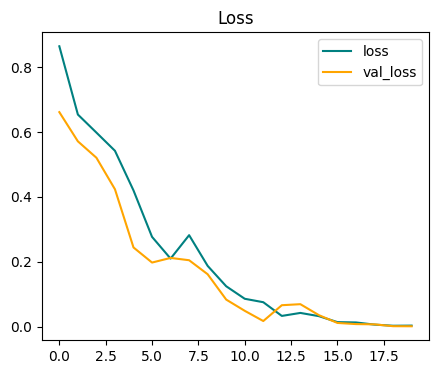

In [45]:
plt.figure(figsize=(5,4))
plt.plot(hist.history['loss'],color='teal',label ='loss')
plt.plot(hist.history['val_loss'],color='orange',label ='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

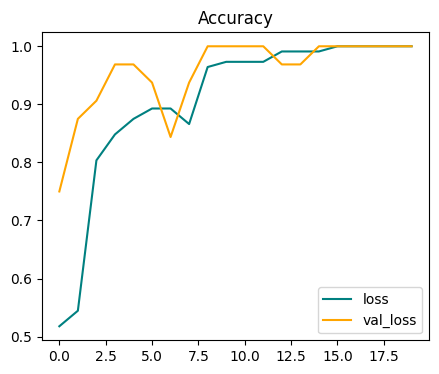

In [46]:
plt.figure(figsize=(5,4))
plt.plot(hist.history['accuracy'],color='teal',label ='loss')
plt.plot(hist.history['val_accuracy'],color='orange',label ='val_loss')
plt.title('Accuracy')
plt.legend()
plt.show()

Evaluate Performance

In [52]:
acc1 = model.evaluate(train)
acc2 = model.evaluate(val)
acc3 = model.evaluate(test)

1/1 [==============================] - 2s 2s/step - loss: 9.1014e-04 - accuracy: 1.0000


In [53]:
print('Training Accuracy : %1.2f%%   Training loss : %1.6f'%(acc1[1]*100,acc1[0]))
print('Validation Accuracy : %1.2f%% Validation loss : %1.6f'%(acc2[1]*100,acc2[0]))
print('Testing Accuracy : %1.2f%%   Testing loss : %1.6f'%(acc3[1]*100,acc3[0]))

Training Accuracy : 100.00%   Training loss : 0.001724
Validation Accuracy : 100.00% Validation loss : 0.001848
Testing Accuracy : 100.00%   Testing loss : 0.000910


In [54]:
import cv2

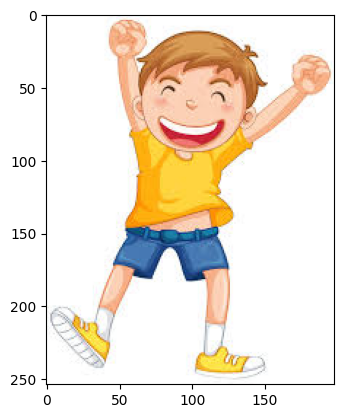

In [76]:
img =cv2.imread('/content/happytest4.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

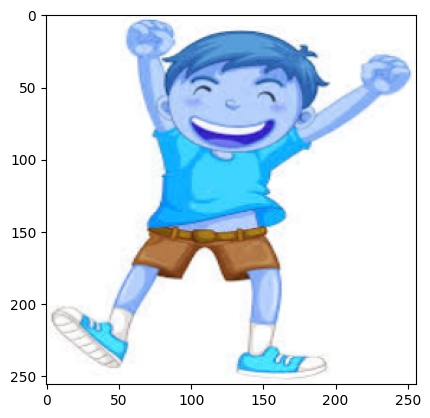

In [77]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [78]:
yhat =model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 18ms/step


In [79]:
if yhat>0.5:
  print(f'Predicted class is sad')
else:
  print(f'Predicted class is happy')

Predicted class is happy


Save model

In [81]:
model.save("/content/drive/MyDrive/Saved models/image sentiment classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
